In [2]:
import numpy as np
import pandas as pd
import cv2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances,log_loss

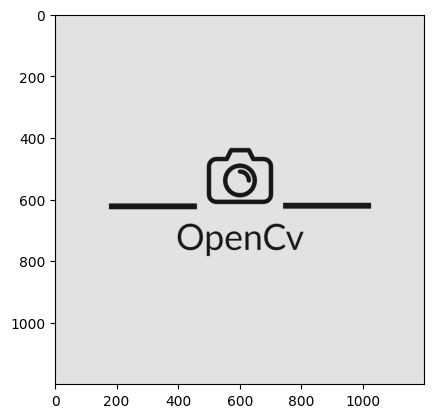

In [3]:
watermark = cv2.imread('3.jpeg')
plt.imshow(watermark)
plt.show()

# Scaling and Rotation of Watermark

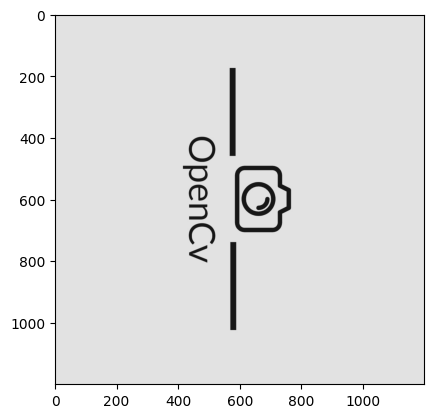

In [2]:
watermark = cv2.imread('3.jpeg')
watermark = cv2.rotate(watermark, cv2.ROTATE_90_CLOCKWISE)
plt.imshow(watermark)
plt.show()

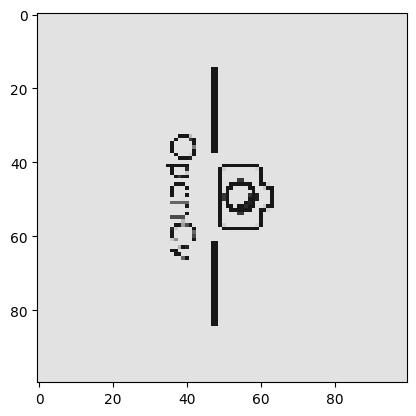

In [3]:
def scale(image,scale_width):
    height = image.shape[0]
    width = image.shape[1]
    scaled_height = (scale_width/height*width)
    scaled_height = int(scaled_height)
    #print(scale_width,scaled_height)
    resized_img = cv2.resize(image,(scale_width,scaled_height))
    return resized_img

watermark = scale(watermark,100)
plt.imshow(watermark)

# Image Inputs

In [4]:
import os
import pathlib
data_dir = './Image Dataset - Copy//'
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('Image Dataset - Copy')

In [5]:
img_list = list(data_dir.glob('*'))
oimg = []
for imgs in img_list:
    pic = cv2.imread(str(imgs))
    oimg.append(pic)

In [6]:
oimg = np.array(oimg)

# Watermark Addition

In [7]:
def logloss(y_true, y_pred, eps=1e-15):
    y_pred = np.clip(y_pred, eps, 1 - eps)
    return -(y_true * np.log(y_pred)).sum(axis=1).mean()

In [8]:
def watermark_func(x,watermark):
    new_img = []
    mse_loss = []
    path = 'E:\IIT JODHPUR AI\Courses Materials\Projects\Computer Vision\Rotated Watermarked Images'
    j=0
    watermark = scale(watermark,100)
    watermark_height = watermark.shape[0]
    watermark_width = watermark.shape[1]
    pairwise = []
    log = []
    for i in x:
        img_height = i.shape[0]
        img_width = i.shape[1]
        overlay = np.zeros((img_height,img_width,3),dtype='uint8')
        overlay[0:watermark_height,0:watermark_width] = watermark
        new = cv2.addWeighted(overlay.copy(),0.8,i.copy(),1.0,0,i.copy())
        new_img.append(new)
        k = "Rotated Watermarked Images/" +str(j)+".jpg"
        #print((k))
        j = j+1
        cv2.imwrite(str(k),new)
        mse_loss.append(mean_squared_error(i.reshape(3,img_height*img_width), new.reshape(3,img_height*img_width)))
        pairwise.append(pairwise_distances(i.reshape(3,img_height*img_width), new.reshape(3,img_height*img_width)).mean())
        log.append(logloss(i.reshape(3,img_height*img_width), new.reshape(3,img_height*img_width)))
    return new_img,mse_loss,pairwise,log

In [9]:
images,mse,pairwise,log = watermark_func(oimg,watermark)

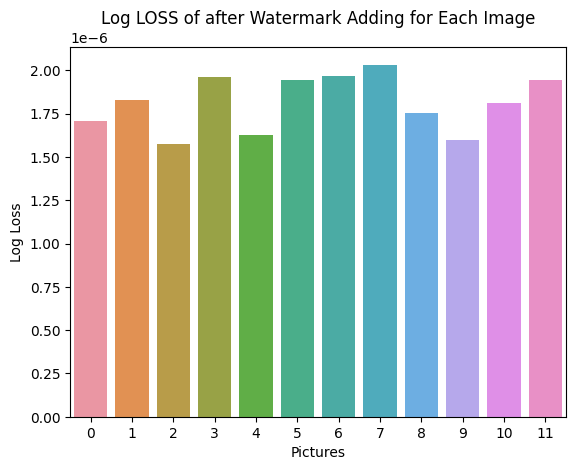

In [10]:
import seaborn as sns 
sns.barplot(y = log,x = np.arange(0,len(oimg),1))
plt.title("Log LOSS of after Watermark Adding for Each Image")
plt.xlabel('Pictures')
plt.ylabel('Log Loss')
plt.show()

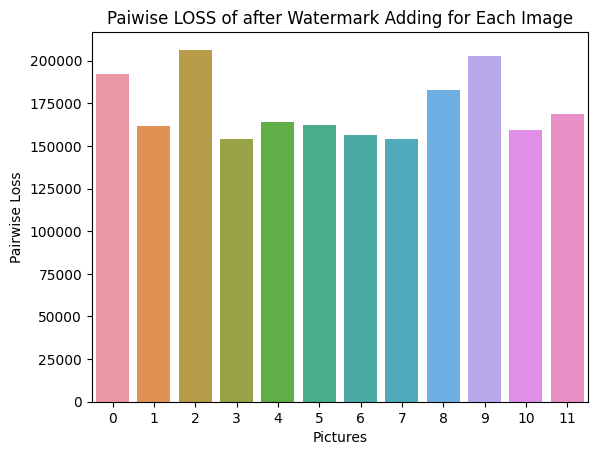

In [11]:
import seaborn as sns 
sns.barplot(y = pairwise,x = np.arange(0,len(oimg),1))
plt.title("Paiwise LOSS of after Watermark Adding for Each Image")
plt.xlabel('Pictures')
plt.ylabel('Pairwise Loss')
plt.show()

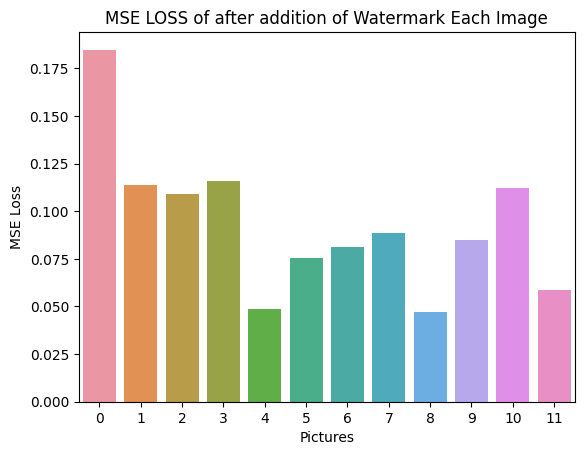

In [12]:
import seaborn as sns 
sns.barplot(y = mse,x = np.arange(0,len(oimg),1))
plt.title("MSE LOSS of after addition of Watermark Each Image")
plt.xlabel('Pictures')
plt.ylabel('MSE Loss')
plt.show()

# Reading the Watermarked Images

In [13]:
import os
import pathlib
data_dir = './Rotated Watermarked Images//'
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('Rotated Watermarked Images')

In [14]:
img_list = list(data_dir.glob('*'))
watermark_imgs = []
for imgs in img_list:
    pic = cv2.imread(str(imgs))
    watermark_imgs.append(pic)
watermark_imgs = np.array(watermark_imgs)

In [15]:
def orb(imgs,watermark):
    template = cv2.imread('3.jpeg', cv2.IMREAD_GRAYSCALE)
    template = scale(template,100)
    detected = []
    removed = []
    mse_loss = []
    pairwise = []
    log = []
    j = 0
    for i,img in enumerate(imgs):
        img_height = img.shape[0]
        img_width = img.shape[1]
        gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)
        orb = cv2.ORB_create(nfeatures=5000)
        kp1, des1 = orb.detectAndCompute(template, None)
        kp2, des2 = orb.detectAndCompute(gray, None)

        # Initialize the Brute-Force Matcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match the descriptors of the template and the original image
        matches = bf.match(des1, des2)

        # Sort the matches in the order of their distance
        matches = sorted(matches, key=lambda x: x.distance)
        num_matches = 15
        x_list = [0]
        y_list = [0]
        for match in matches[:num_matches]:
            x, y = kp2[match.trainIdx].pt
            x_list.append(x)
            y_list.append(y)
        #print(np.min(x_list),np.min(y_list))
        # Get the median of the keypoints
        x = int(np.min(x_list))
        y = int(np.min(y_list))

        # Get the dimensions of the template
        w, h = template.shape[::-1]

        # Draw a rectangle around the matched region in the original image
        new = cv2.rectangle(img.copy(), (x, y), (x + w, y + h), (0, 255, 0), 5)
        detected.append(new)
        
        top_left = [0,0]
        bottom_right = (top_left[0] + w, top_left[1] + h)

        # Create a mask of the area to be inpainted
        mask = np.zeros(new.shape[:2], np.uint8)
        mask[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = 100

        # Inpaint the area where the template was located
        inpainting = cv2.inpaint(img.copy(), mask.copy(), 150, cv2.INPAINT_TELEA)

        removed.append(inpainting)
        mse_loss.append(mean_squared_error(img.reshape(3,img_height*img_width), inpainting.reshape(3,img_height*img_width)))
        pairwise.append(pairwise_distances(img.reshape(3,img_height*img_width), inpainting.reshape(3,img_height*img_width)).mean())
        log.append(logloss(np.array(img.reshape(3,img_height*img_width)), np.array(inpainting.reshape(3,img_height*img_width))))
        k = "wremoved/" +str(j)+".jpg"
        #print((k))
        j = j+1
        cv2.imwrite(str(k),inpainting)
    return detected,removed,mse_loss,pairwise,log

In [16]:
detect,removed,mse,pairwise,log = orb(watermark_imgs,watermark)

In [17]:
log

[1.7098894057321348e-06,
 1.8285104573800839e-06,
 1.814385266030172e-06,
 1.9471921605118685e-06,
 1.5777356531243571e-06,
 1.961440071696075e-06,
 1.6275170644508565e-06,
 1.942329158510781e-06,
 1.9648606698341457e-06,
 2.032747336455643e-06,
 1.7524876629870796e-06,
 1.6001940416066065e-06]

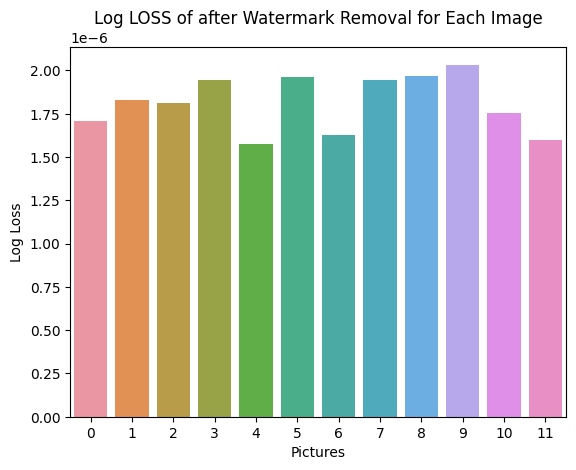

In [18]:
import seaborn as sns 
sns.barplot(y = log,x = np.arange(0,len(oimg),1))
plt.title("Log LOSS of after Watermark Removal for Each Image")
plt.xlabel('Pictures')
plt.ylabel('Log Loss')
plt.show()

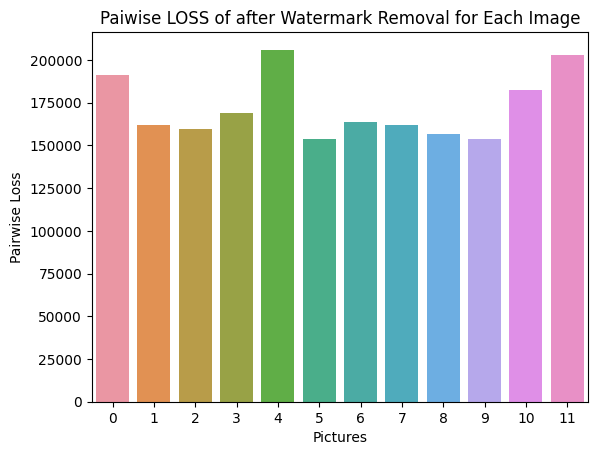

In [19]:
import seaborn as sns 
sns.barplot(y = pairwise,x = np.arange(0,len(oimg),1))
plt.title("Paiwise LOSS of after Watermark Removal for Each Image")
plt.xlabel('Pictures')
plt.ylabel('Pairwise Loss')
plt.show()

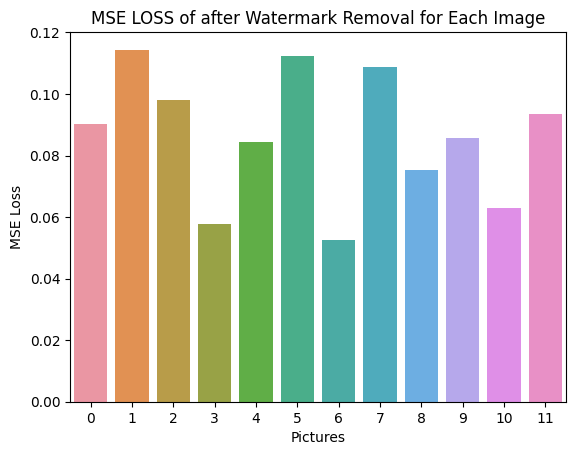

In [20]:
import seaborn as sns 
sns.barplot(y = mse,x = np.arange(0,len(oimg),1))
plt.title("MSE LOSS of after Watermark Removal for Each Image")
plt.xlabel('Pictures')
plt.ylabel('MSE Loss')
plt.show()

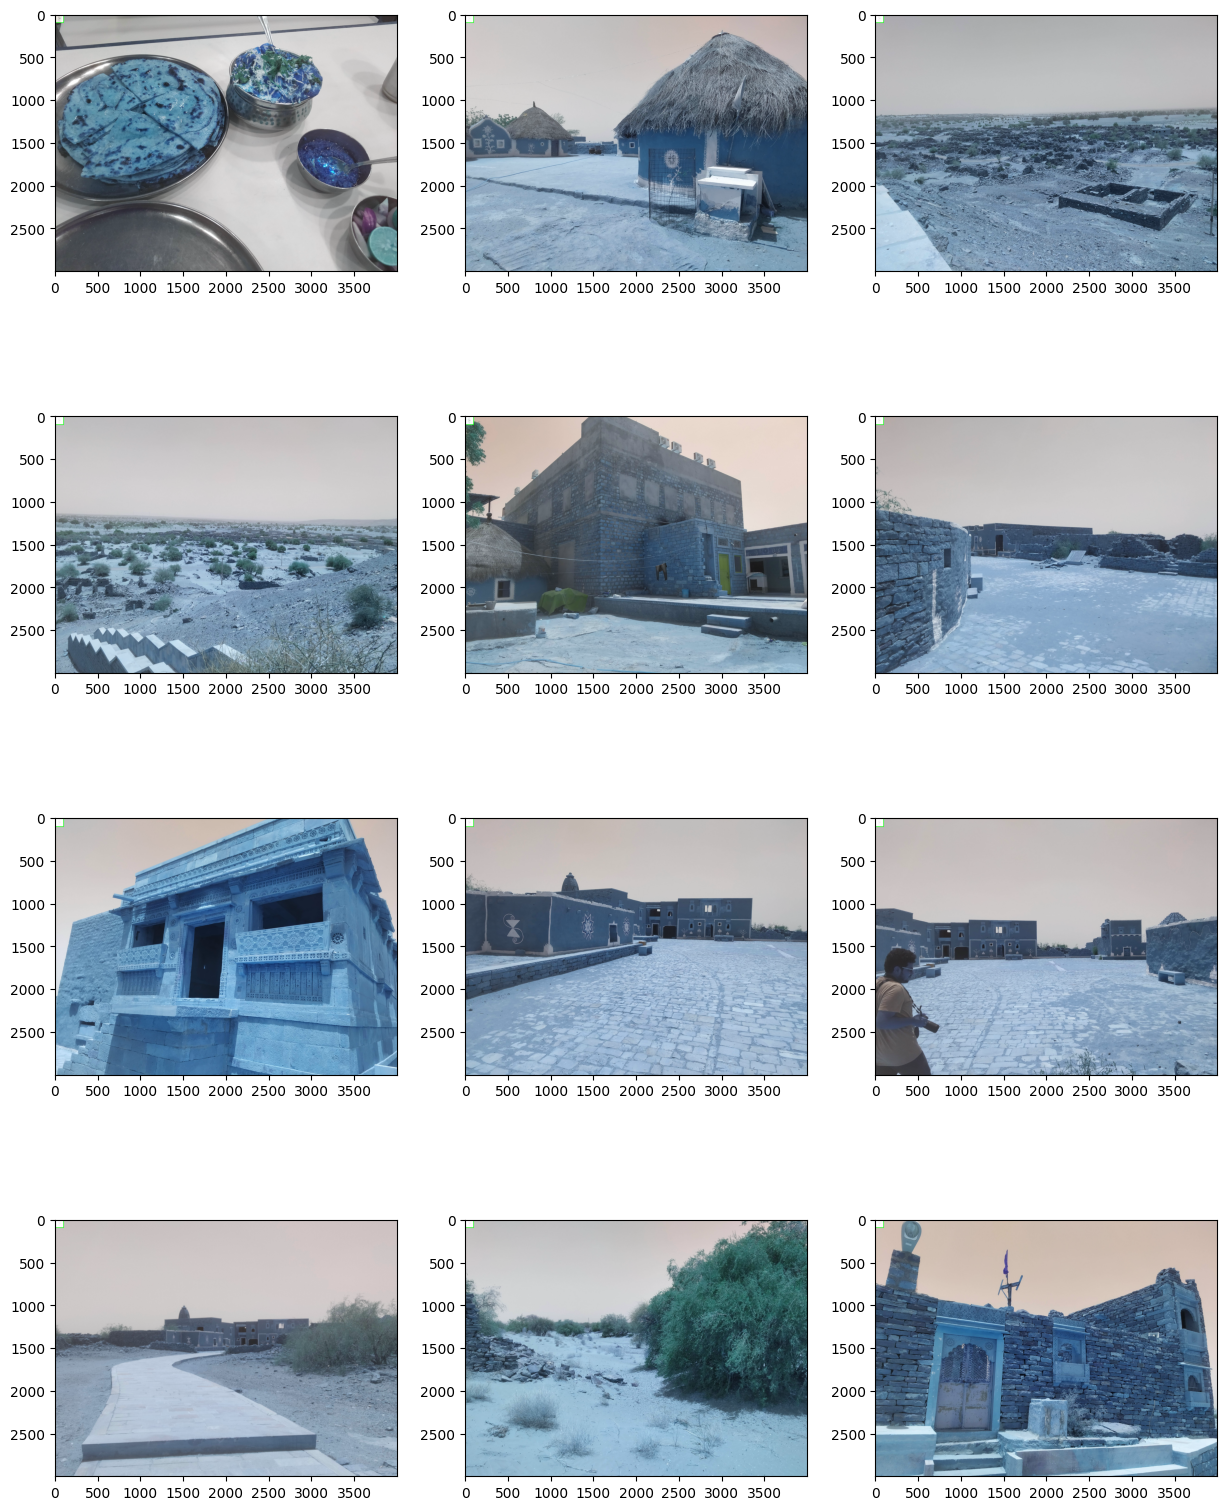

In [21]:
import matplotlib.pyplot as plt

# Display the images from the ss list using subplots with multiple rows
num_imgs = len(oimg)
num_cols = 3
num_rows = (num_imgs + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i in range(num_imgs):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(detect[i])
    
plt.show()


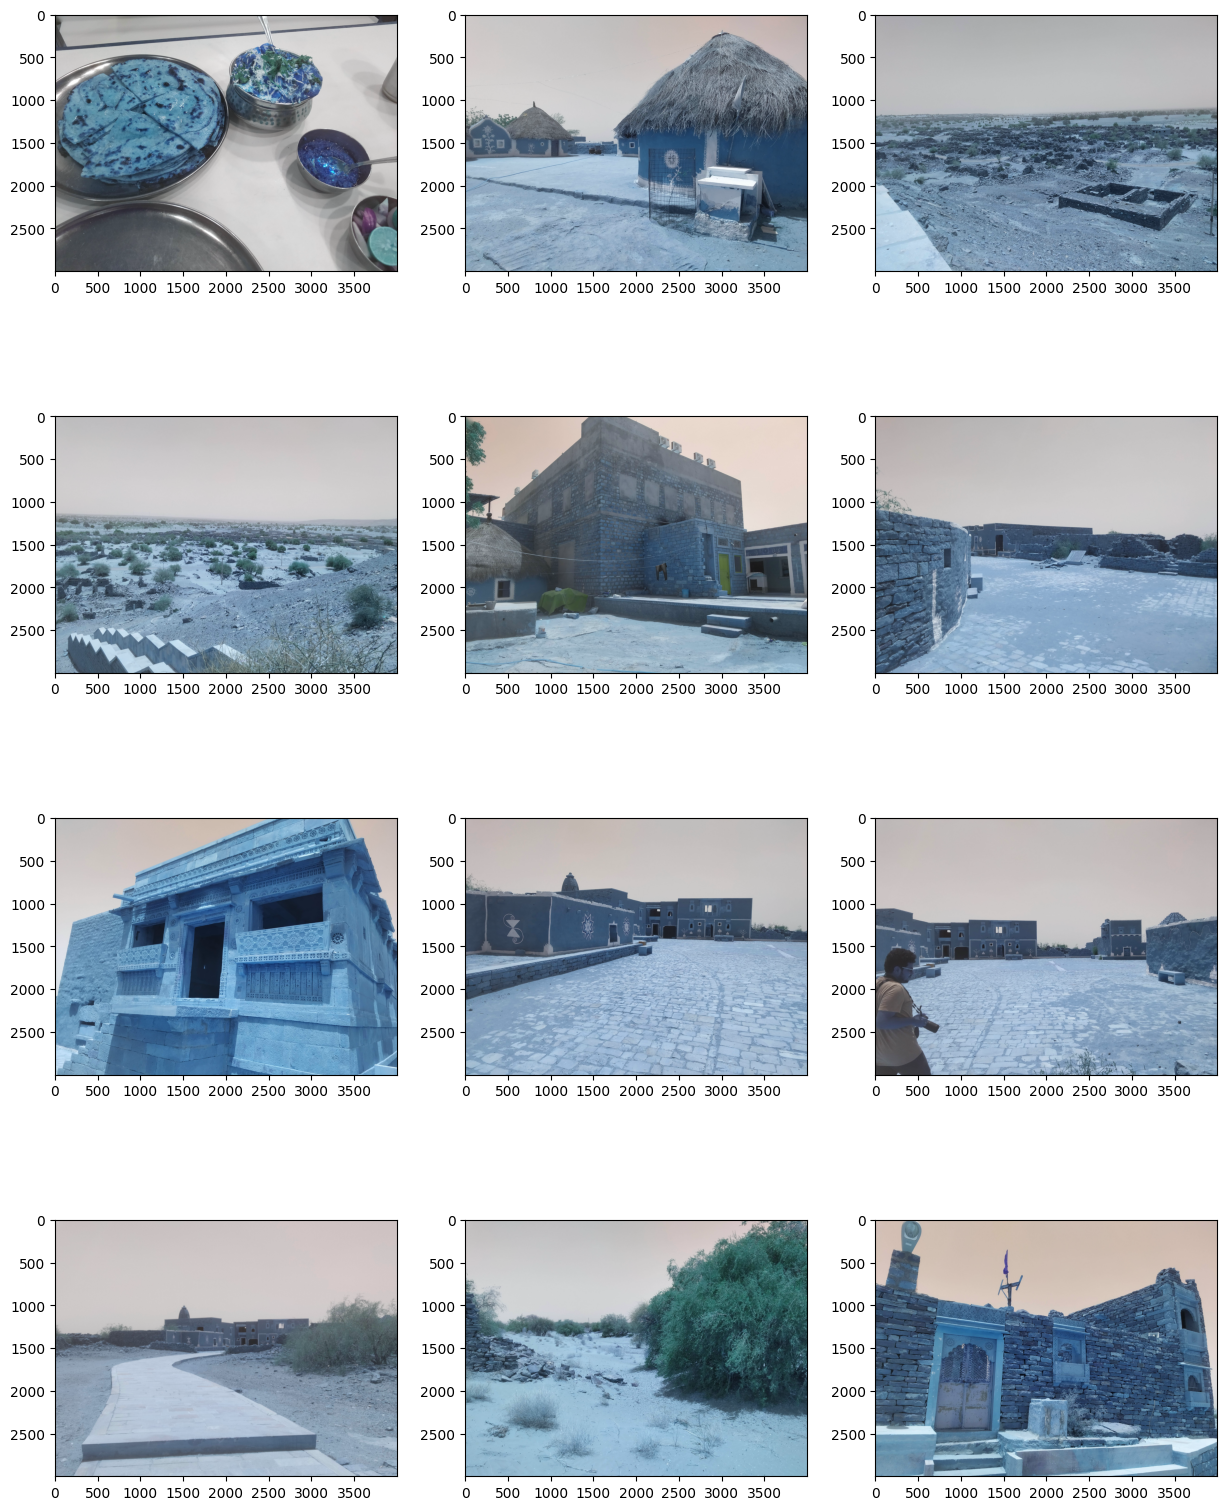

In [22]:
import matplotlib.pyplot as plt

# Display the images from the ss list using subplots with multiple rows
num_imgs = len(oimg)
num_cols = 3
num_rows = (num_imgs + num_cols - 1) // num_cols
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i in range(num_imgs):
    row = i // num_cols
    col = i % num_cols
    axs[row, col].imshow(removed[i])
    
plt.show()


In [23]:
from sklearn.metrics import pairwise_distances
a = np.zeros((5,3))
b = np.ones((5,3))
log_loss(a, b)

0.0

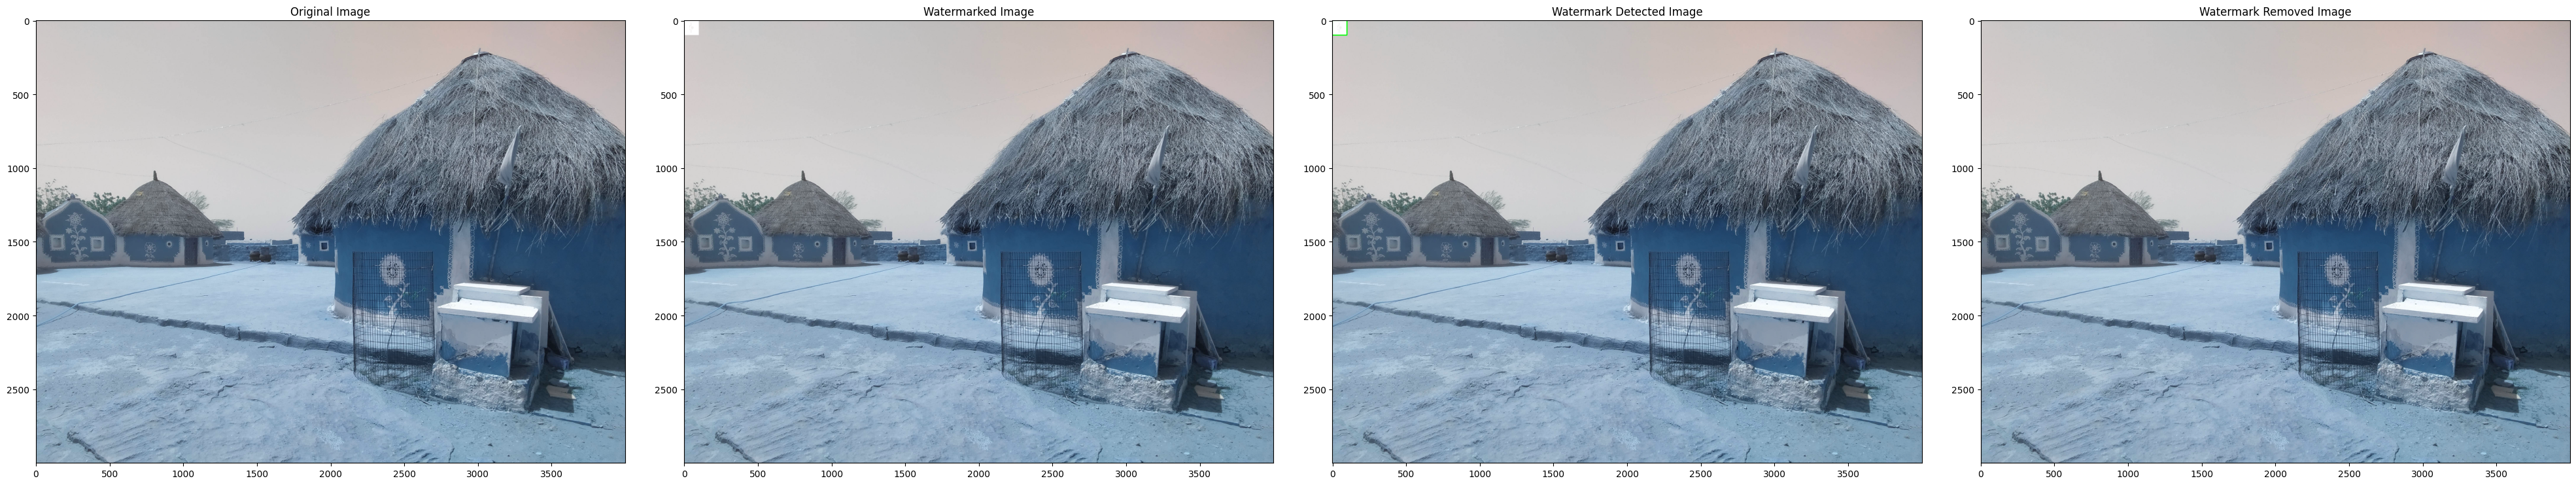

In [26]:
fig, axs = plt.subplots(1, 4, figsize=(50, 40))
axs[0].imshow(oimg[1]),axs[0].set_title('Original Image')
axs[1].imshow(images[1]),axs[1].set_title('Watermarked Image')
axs[2].imshow(detect[1]),axs[2].set_title('Watermark Detected Image')
axs[3].imshow(removed[1]),axs[3].set_title('Watermark Removed Image')
plt.subplots_adjust(wspace=0.1)
plt.show()